Prof notes: Looks good!
- I would start thinking about what is an "outcome" and what is a "predictor", and doing scatterplot or crosstabs to look for patterns
- It sounds like the data require a lot of work and cleaning in order to parse out the star actors, the directors, etc. Some of the code from the PCA lab might be useful here.
- LASSO might be a good fit because it will shrink lots of the one-hot-encoded variables towards zero. Then what you're left with will be the more powerful predictors of movie success.
- Looking forward to seeing your results!


1. State a clear prediction question, not just what you did. Asking clear questions is the key to getting clear answers. You don't need to pick a "client", but sometimes it's helpful to think about the hypothetical scenario in which, say, NOAA or FEMA or a hospital would use your model.

2. Organize your discussion around two or three key tables or plots or numbers. Don't write up everything you did: Focus on your main result, and then add exposition around it until the reader is able to appreciate what you did and why. This keeps your writing from becoming bloated and rambling: Work backwards from the result to the reader's initial conditions.

3. You can handle criticisms or concerns in the results section if they are relevant or interesting, but most probably belong in the conclusion.

4. No pseudo-scientific word salad! If you write something, make it meaningful and interesting. Be clear. Make sure you know what you're talking about, or review the material to ensure you understand it.

5. Don't write about things about which you have no data or did not analyze, unless you are citing someone else's work in relation to what you are doing.

6. If you are tempted to make causal claims about a variable X causing Y, instead cast it as an explainability discussion. (e.g. "In this model, as yacht ownership increases, predictions of life expectancy tend to increase as well, possibly reflecting an omitted variable bias between wealth and health." You can of course discuss how yacht ownership and life expectancy are related, but of course yachts don't per se cause longevity.)



# Introduction
Understanding what drives a movie's financial success is a critical challenge for the film industry. By identifying key predictors of revenue, studios can make informed decisions about budgeting, marketing, and release strategies. This analysis focuses on predicting movie revenue using a streamlined set of predictors: budget, audience ratings (vote count and average), director gender, and release date.

Our goal is to develop a regression model that evaluates how these factors contribute to box office performance. Budget reflects the scale of production and marketing efforts, while vote count and average represent audience reception and critical acclaim. Director gender provides insight into demographic influences, and release date captures seasonal and temporal trends that may affect audience turnout.

Through this approach, we aim to highlight the relative importance of these predictors in driving revenue, offering actionable insights for optimizing future film projects. By focusing on these targeted variables, we provide a practical framework for understanding the interplay between production decisions and financial outcomes in the movie industry.

In [ ]:
import pandas as pd

directors = pd.read_csv("data/directors.csv")
movies = pd.read_csv("data/movies.csv")

# Get rid of movies that cost no money or made no money (these seem erroneous or just bad data points regardless?)
movies = movies.drop(movies[movies.revenue == 0].index)
movies = movies.drop(movies[movies.budget == 0].index)

# Length of title as possible indicator of success
movies['title_word_count'] = movies['title'].str.split().str.len()

# Get rid of the column that is just the index from the data set
movies.drop('Unnamed: 0', axis=1, inplace=True)

# Take gender column from directors and bring into movies
director_gender_dict = directors.set_index('id')['gender']
movies['director_id'] = movies['director_id'].astype(directors['id'].dtype)
movies['dir_gender'] = movies['director_id'].map(director_gender_dict)

# Still left with about 1200
movies.describe()

,id,budget,popularity,revenue,vote_average,vote_count,director_id,year,title_word_count
count,1239.000000,1.239000e+03,1239.000000,1.239000e+03,1239.000000,1239.000000,1239.000000,1239.000000,1239.000000
mean,45057.979015,5.486410e+07,34.866828,1.683258e+08,6.410977,1325.239709,5011.858757,2002.773204,2.752220
std,1109.276646,5.015137e+07,36.355286,2.150666e+08,0.812727,1652.486891,232.109408,8.719061,1.644723
min,43597.000000,1.000000e+04,0.000000,4.600000e+01,3.000000,9.000000,4762.000000,1976.000000,1.000000
25%,44129.500000,2.000000e+07,15.000000,3.907801e+07,5.900000,330.500000,4833.000000,1998.000000,2.000000
50%,44836.000000,4.000000e+07,27.000000,1.008538e+08,6.500000,755.000000,4947.000000,2004.000000,2.000000
75%,45730.500000,7.500000e+07,44.000000,2.083560e+08,7.000000,1582.000000,5130.000000,2010.000000,3.000000
max,48395.000000,3.800000e+08,724.000000,2.787965e+09,8.300000,13752.000000,6204.000000,2016.000000,12.000000


In [ ]:
movies.head()

,id,budget,popularity,revenue,title,vote_average,vote_count,director_id,year,month,day,title_word_count,dir_gender
0,43597,237000000,150,2787965087,Avatar,7.2,11800,4762,2009,Dec,Thursday,1,Male
1,43598,300000000,139,961000000,Pirates of the Caribbean: At World's End,6.9,4500,4763,2007,May,Saturday,7,Male
2,43599,245000000,107,880674609,Spectre,6.3,4466,4764,2015,Oct,Monday,1,Male
3,43600,250000000,112,1084939099,The Dark Knight Rises,7.6,9106,4765,2012,Jul,Monday,4,Male
4,43602,258000000,115,890871626,Spider-Man 3,5.9,3576,4767,2007,May,Tuesday,2,Male


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

"""
Regressing on all the variables we've got in the dataset as a starting point to see multivariate linear regression performance.
From here could be good to try without certain variables to reduce overfitting, and looking into other ways to increase model performance.
"""

numeric_features = [
    'budget',
    'popularity',
    'vote_average',
    'vote_count',
    'year',
    'title_word_count',
]

categorical_features = [
    'dir_gender',
    'month',
    'day',
]

target = 'revenue'

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Basically just using all the general setup from lab examples

X = movies[numeric_features + categorical_features]
y = movies[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared Score:", r2_score(y_test, y_pred))
print()

feature_names = (
    numeric_features +
    list(model.named_steps['preprocessor']
         .named_transformers_['cat']
         .get_feature_names_out(categorical_features))
)

# Show us all the coefficient values (i.e. how does this variable effect our overall score?)
coefficients = model.named_steps['regressor'].coef_
for name, coef in zip(feature_names, coefficients):
    print(f"{name}: {coef}")

Mean Squared Error: 1.5027985840445938e+16
R-squared Score: 0.6472199749635876

budget: 91236411.22618939
popularity: 7768677.241590828
vote_average: -12497103.305226754
vote_count: 109417057.84917945
year: -18443405.302621156
title_word_count: 9085187.37200402
dir_gender_Male: -2231554.2122005518
dir_gender_nan: -1352422.6130282877
month_Aug: -7190901.635891752
month_Dec: 34478533.39780153
month_Feb: -34861243.94652491
month_Jan: -16297035.23701227
month_Jul: -8129209.975163378
month_Jun: 18235251.204572827
month_Mar: -17519475.33923537
month_May: 18968851.860462613
month_Nov: 36057081.494834445
month_Oct: -17107757.632951077
month_Sep: -7662446.58020678
day_Monday: -4457799.016432298
day_Saturday: -10578975.943551894
day_Sunday: 10042193.983900052
day_Thursday: -4198816.220084275
day_Tuesday: 31616751.71004256
day_Wednesday: -9118627.23572576


Takeaways thus far:
- R^2 is 0.63, which is pretty solid performance. Generally, > 0.5 is ideal. Closer to 0.7 should be a target. PCA may be helpful for this.
- MSE is really big (1.57e+16) but this is probably ok (?) since some movies are less popular while others (e.g. Avatar) have huge box office performance
  - maybe look into this though
- budget is highly correlated which seems fairly obvious
- male directors on average perform better, but NaN even more so (might just be coincidence)
- december and november do quite well, maybe due to Christmas/family holidays/it's winter so nothing else to do
- days seem a bit arbitrary (i don't see why Tuesday would perform better than Saturday)
- the year one is a bit odd to me, but maybe this is due to inflation or some sort of lack of adjustment
  - doing a basic plot shows that revenue seems to definitely increase (though not as much as i expected
- after the fact I've added a title_length and this seems to have brought MSE down to 1.5e+16 and R2 to 0.647, which is a decent boost for a little extra calculation

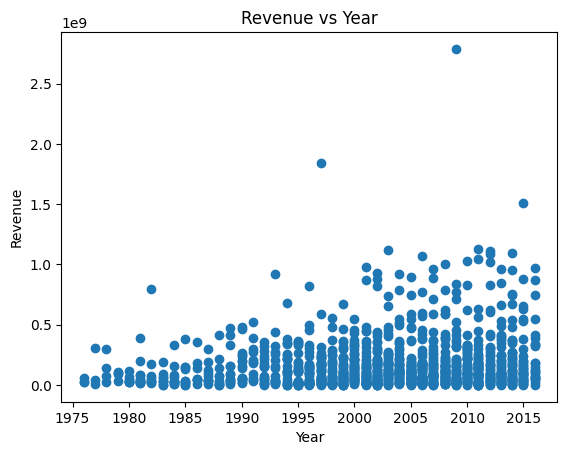

             year   revenue
year     1.000000  0.144894
revenue  0.144894  1.000000


In [ ]:
import matplotlib.pyplot as plt
plt.scatter(movies['year'], movies['revenue'])
plt.title('Revenue vs Year')
plt.xlabel('Year')
plt.ylabel('Revenue')
plt.show()

print(movies[['year', 'revenue']].corr())

In [ ]:
X = movies[['budget', 'vote_average']]
y = movies['revenue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Coefficients:")
for feature, coef in zip(['budget', 'vote_average'], model.coef_):
    print(f"{feature}: {coef}")

print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

Coefficients:
budget: 156055543.29145414
vote_average: 49237562.81437383
Mean Squared Error: 2.067549316290047e+16
R-squared Score: 0.5146454705847817


MSE and R2 perform worse with just budget and vote average. Was curious to see if the other stuff was just adding noise.

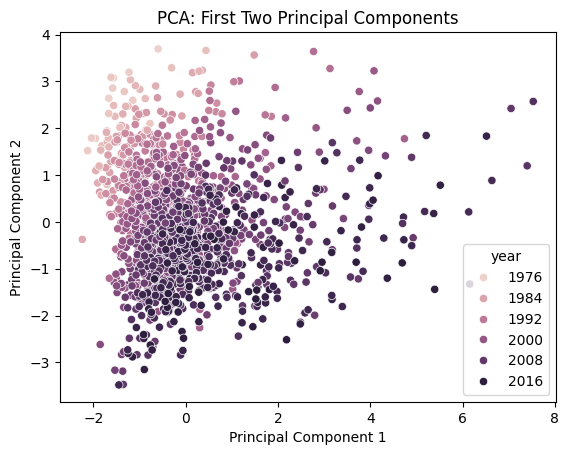

Train R^2: 0.6226448220043007
Test R^2: 0.642971603829902


In [3]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('movies.csv')

# Select relevant features
features = ['budget', 'vote_count', 'vote_average', 'year']
X = data[features]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=2)  # Adjust number of components based on explained variance
principal_components = pca.fit_transform(X_scaled)

# Add principal components to the dataset for analysis
data['PC1'] = principal_components[:, 0]
data['PC2'] = principal_components[:, 1]

# Visualize first two principal components (scatter plot)
sns.scatterplot(x=data['PC1'], y=data['PC2'], hue=data['year'])  # Example hue variable
plt.title('PCA: First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Split data for regression analysis
y = data['revenue']  # target variable
X_train, X_test, y_train, y_test = train_test_split(principal_components, y, test_size=0.2, random_state=42)

# Linear regression on principal components
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions and performance evaluation
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print('Train R^2:', r2_score(y_train, y_train_pred))
print('Test R^2:', r2_score(y_test, y_test_pred))